In [1]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
import matplotlib.pyplot as plt
import emcee
import random
from getdist import MCSamples, plots
import acor

In [9]:
#INSTRUMENT
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)
print(instr_['frequency'])


#SKY MAP
nside = 4
freq_maps = get_observation(instrument, 'd0s0', noise=False, nside=nside)
components= [CMB(),Dust(50.),Synchrotron(50.)]
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)


#NOISE
invN=np.linalg.inv(np.eye(len(instrument.frequency)))
#invN = np.diag((hp.nside2resol(nside, arcmin=True) / instrument.depth_p)**2)


#INITIAL PARAMETER
x0 =np.array([1.54,20,-3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])



def lnprior(y):
    Bd, Td, Bs, a, b, c, d, e, f, g, i, l, m , n, o, p, q, r, s, t, u, v, w, z = y
    if ((Bd < 0.) or (Bd > 2.) or
        (Td < 10.) or (Td > 30.) or
        (Bs < -4.) or (Bs > -2.) or  
        (a < 0.) or
        (b < 0.) or
        (c < 0.) or
        (d < 0.) or
        (e < 0.) or
        (f < 0.) or
        (g < 0.) or
        (i < 0.) or
        (l < 0.) or
        (m < 0.) or
        (n < 0.) or
        (o < 0.) or
        (p < 0.) or
        (q < 0.) or
        (r < 0.) or
        (s < 0.) or
        (t < 0.) or
        (u < 0.) or
        (v < 0.) or
        (w < 0.) or
        (z < 0.)):
        return -np.inf
    else:
        return 0.0
    


def spec_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
    h= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z])
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    if logL != logL:
        return 0.0
    return logL

def lnprob(x):
    lp = lnprior(x)
    return lp + spec_likelihood(x)


[ 40.  50.  60.  68.  68.  78.  78.  89.  89. 100. 119. 140. 100. 119.
 140. 166. 195. 195. 235. 280. 337. 402.]


In [10]:


random.seed(10)
nwalkers, ndim = 50, 24
pos = np.random.uniform(low=x0 * (1 - 1 / 4), high= x0 * (1 + 1 / 4), size=(nwalkers, ndim))

100%|██████████| 1000/1000 [00:09<00:00, 103.09it/s]


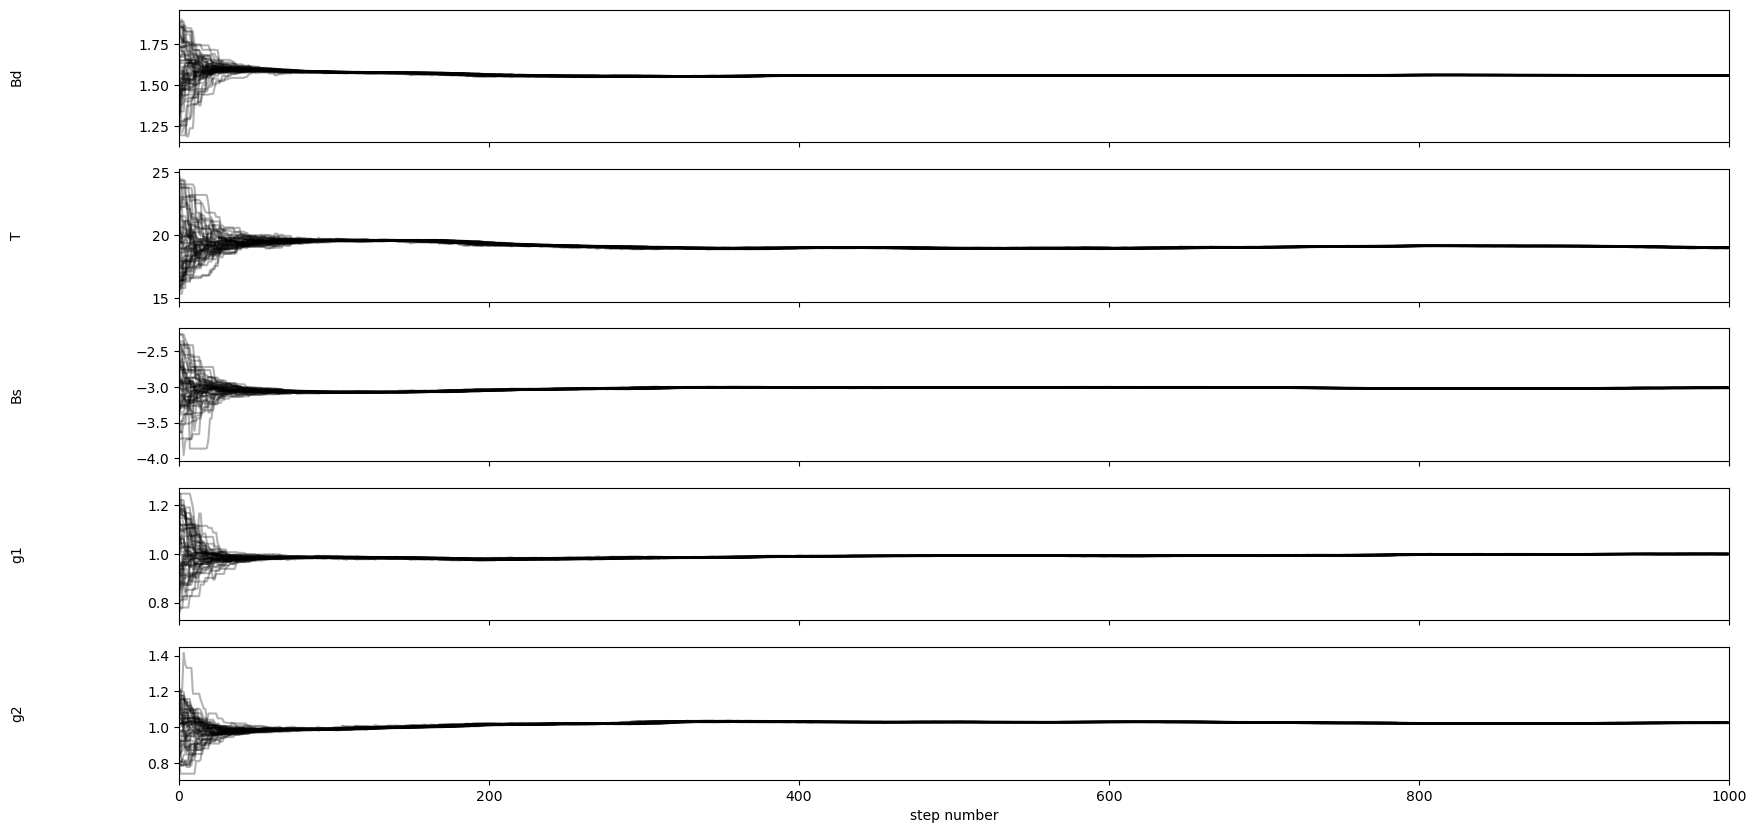

In [11]:

#SAMPLE
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(pos,1000, progress=True)
samples = sampler.get_chain(flat=False)


ndim=5
fig, axes = plt.subplots(5, figsize=(20,10), sharex=True)
labels=["Bd", "T", "Bs", "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Removed no burn in


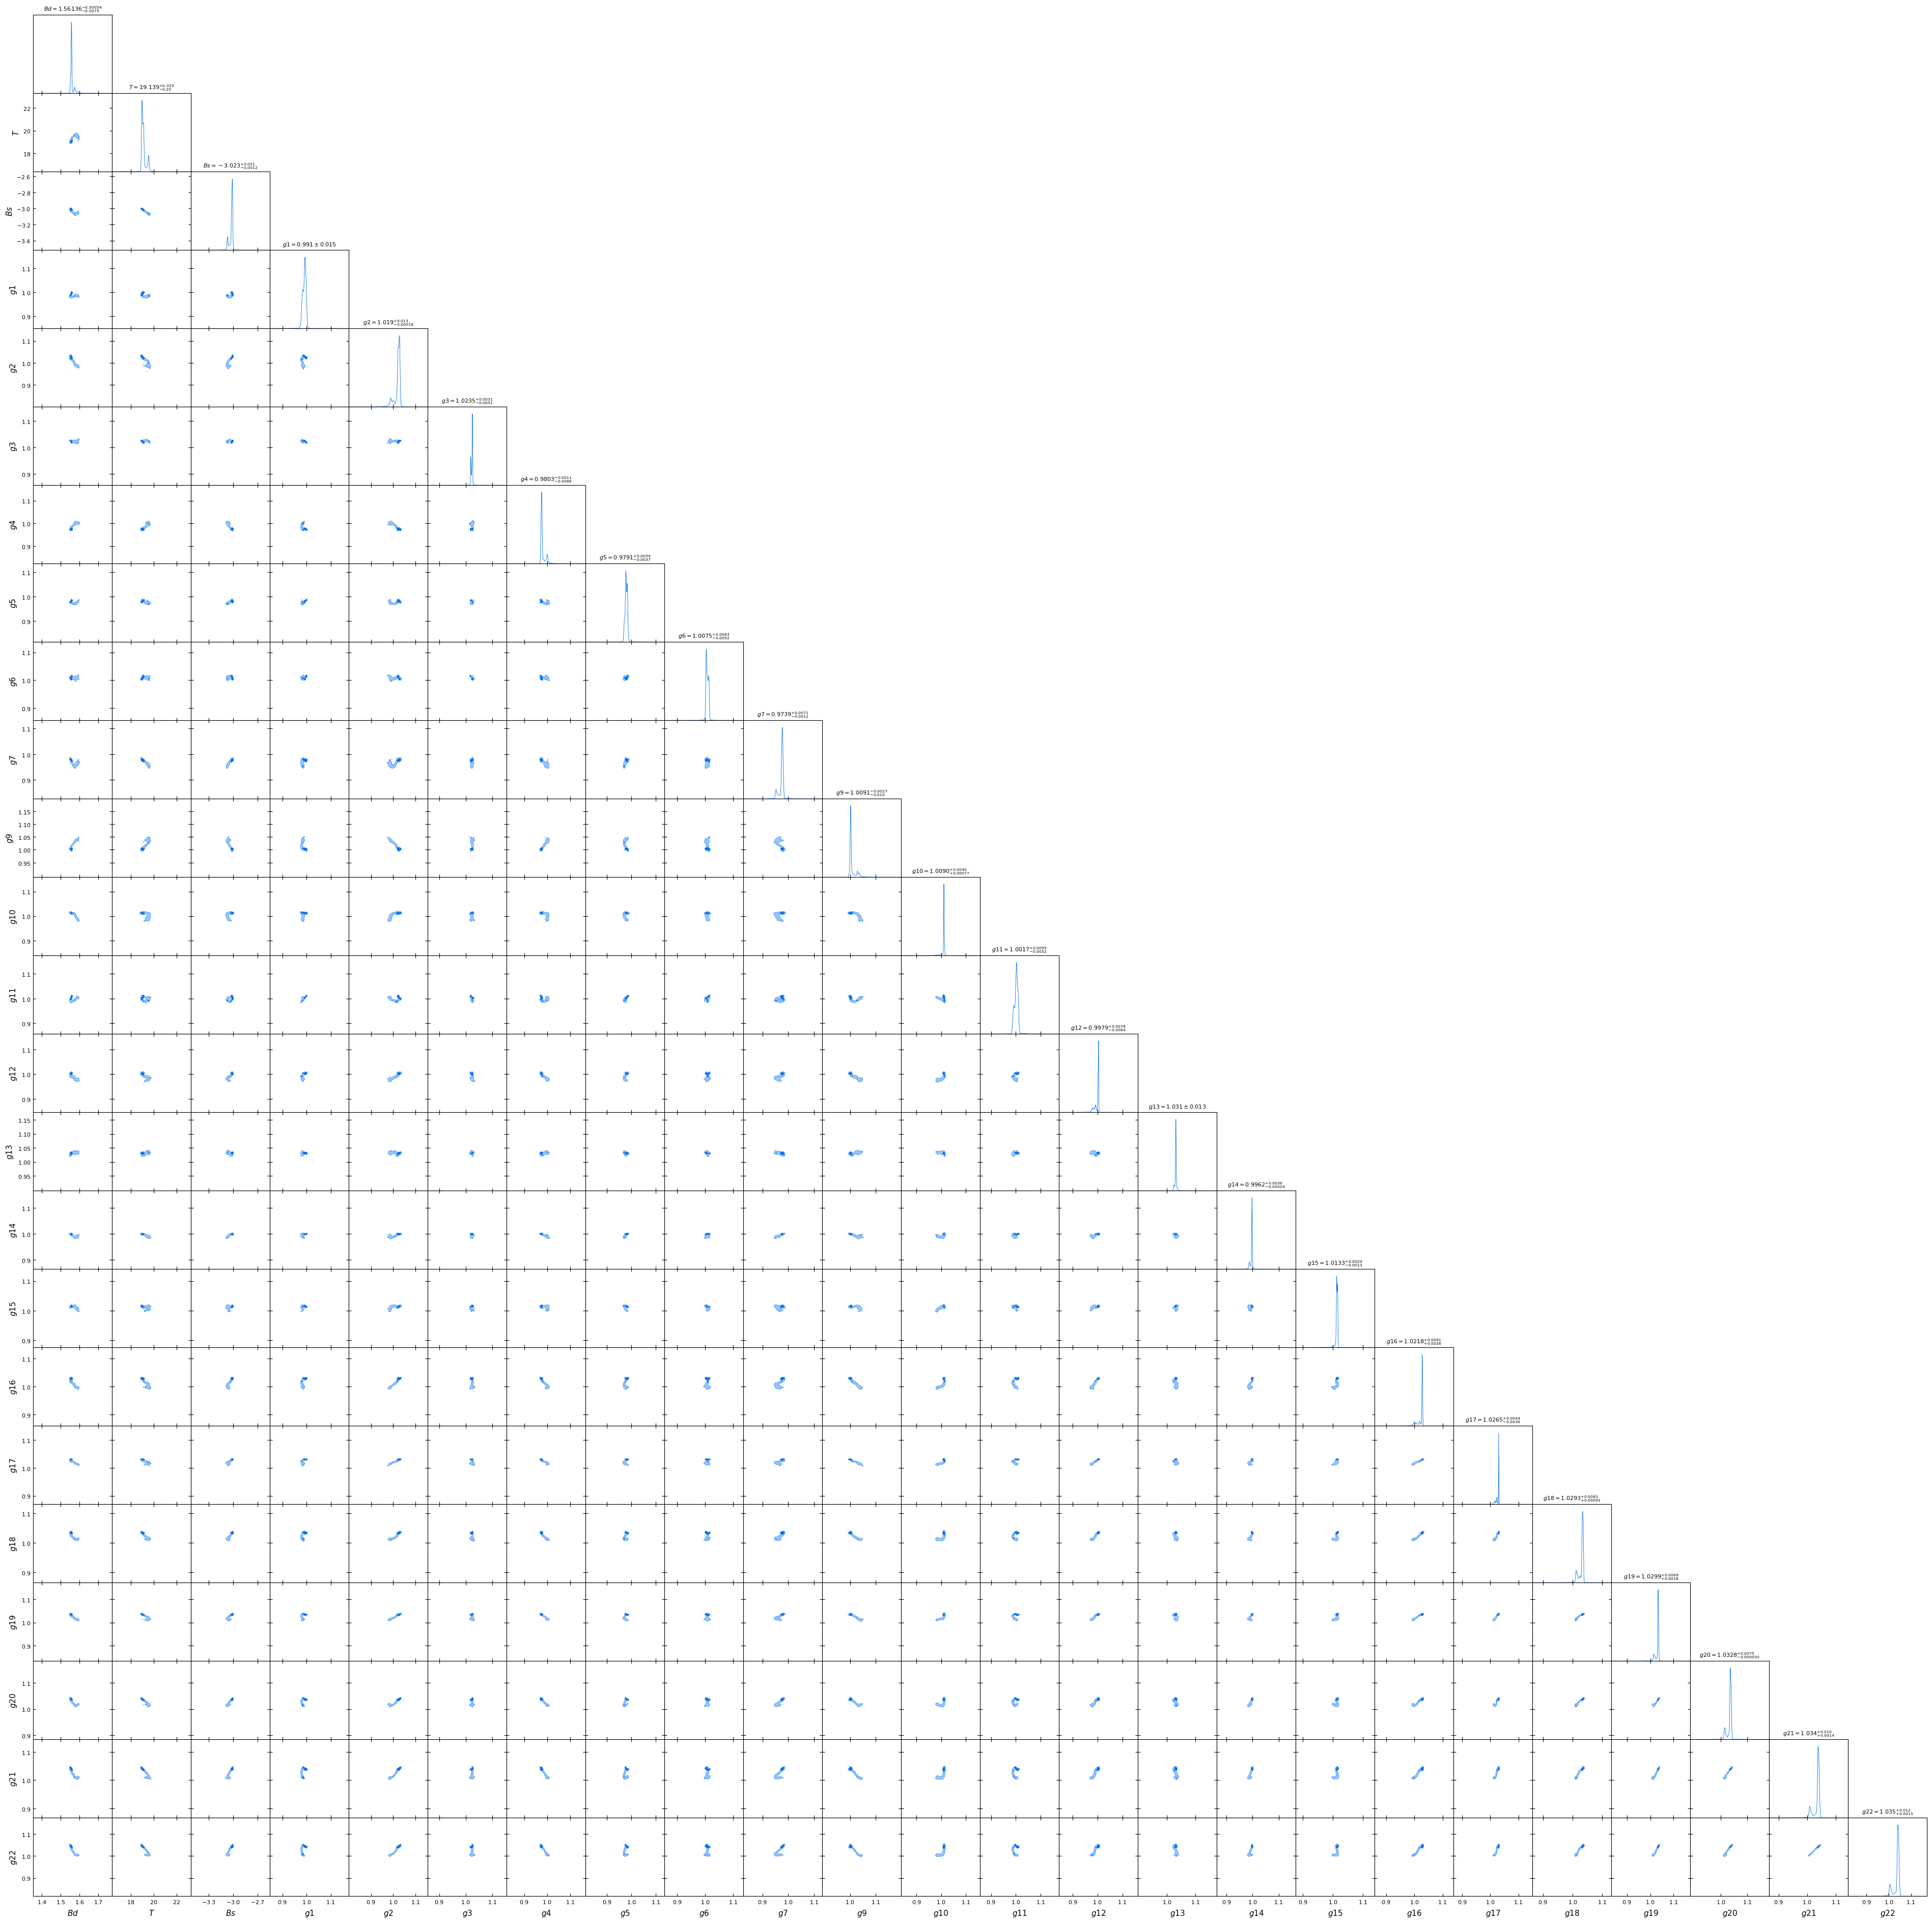

In [12]:
s1 = MCSamples(samples=samples, names=["Bd", "T", "Bs",  "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ], labels=["Bd", "T", "Bs",  "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ], label='21g')
g = plots.get_subplot_plotter()
g.triangle_plot([s1], filled=True, title_limit= True)
plt.show()

In [19]:
#AUTOCORRELATION TIME
tau = sampler.get_autocorr_time(quiet=True)
flat_samples = sampler.get_chain(discard=2*int(max(tau)), thin=int(max(tau)), flat=True)

N/50 = 20;
tau: [ 54.15952952  67.72583587  72.4594385   96.50952224  85.40343355
  42.51319889  80.83942434  74.3715315   47.55147038  47.69942354
 106.16063886  42.36016102  87.0194405   92.94996026  23.84292307
  38.62076737  26.74760222  93.61938373  69.37710939  82.67151378
  68.1147795   63.16201082  80.99618933  84.86394989]


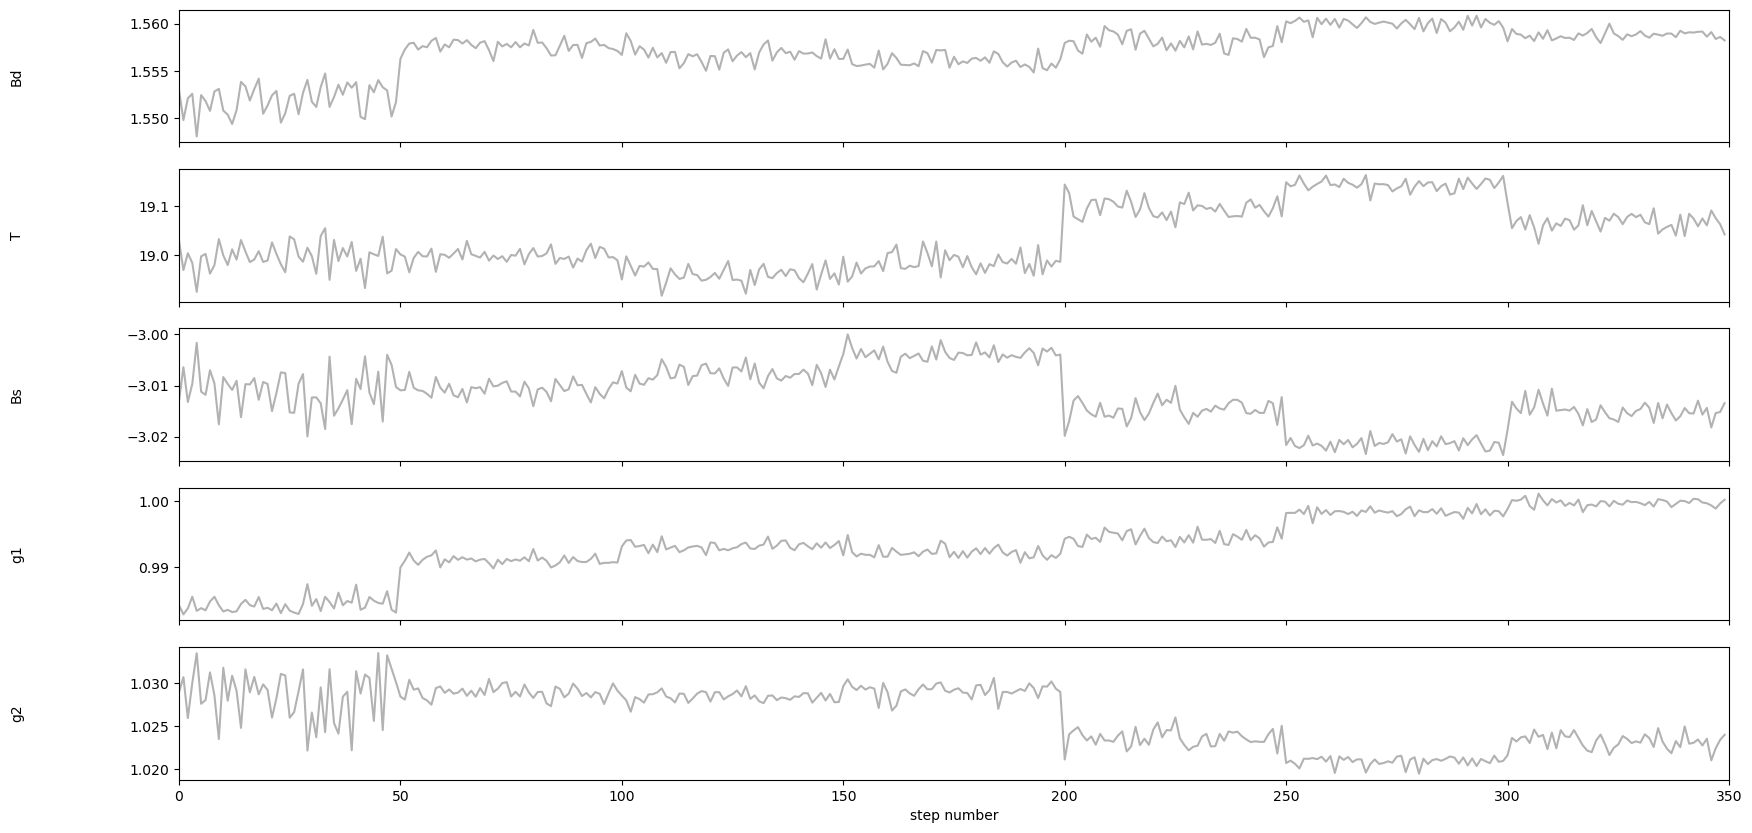

In [16]:
new_samples = sampler.get_chain(discard=2*int(max(tau)), thin=int(max(tau)), flat=True)
ndim=5
fig, axes = plt.subplots(5, figsize=(20,10), sharex=True)
labels=["Bd", "T", "Bs", "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ]
for i in range(ndim):
    ax = axes[i]
    ax.plot(new_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(new_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Removed no burn in


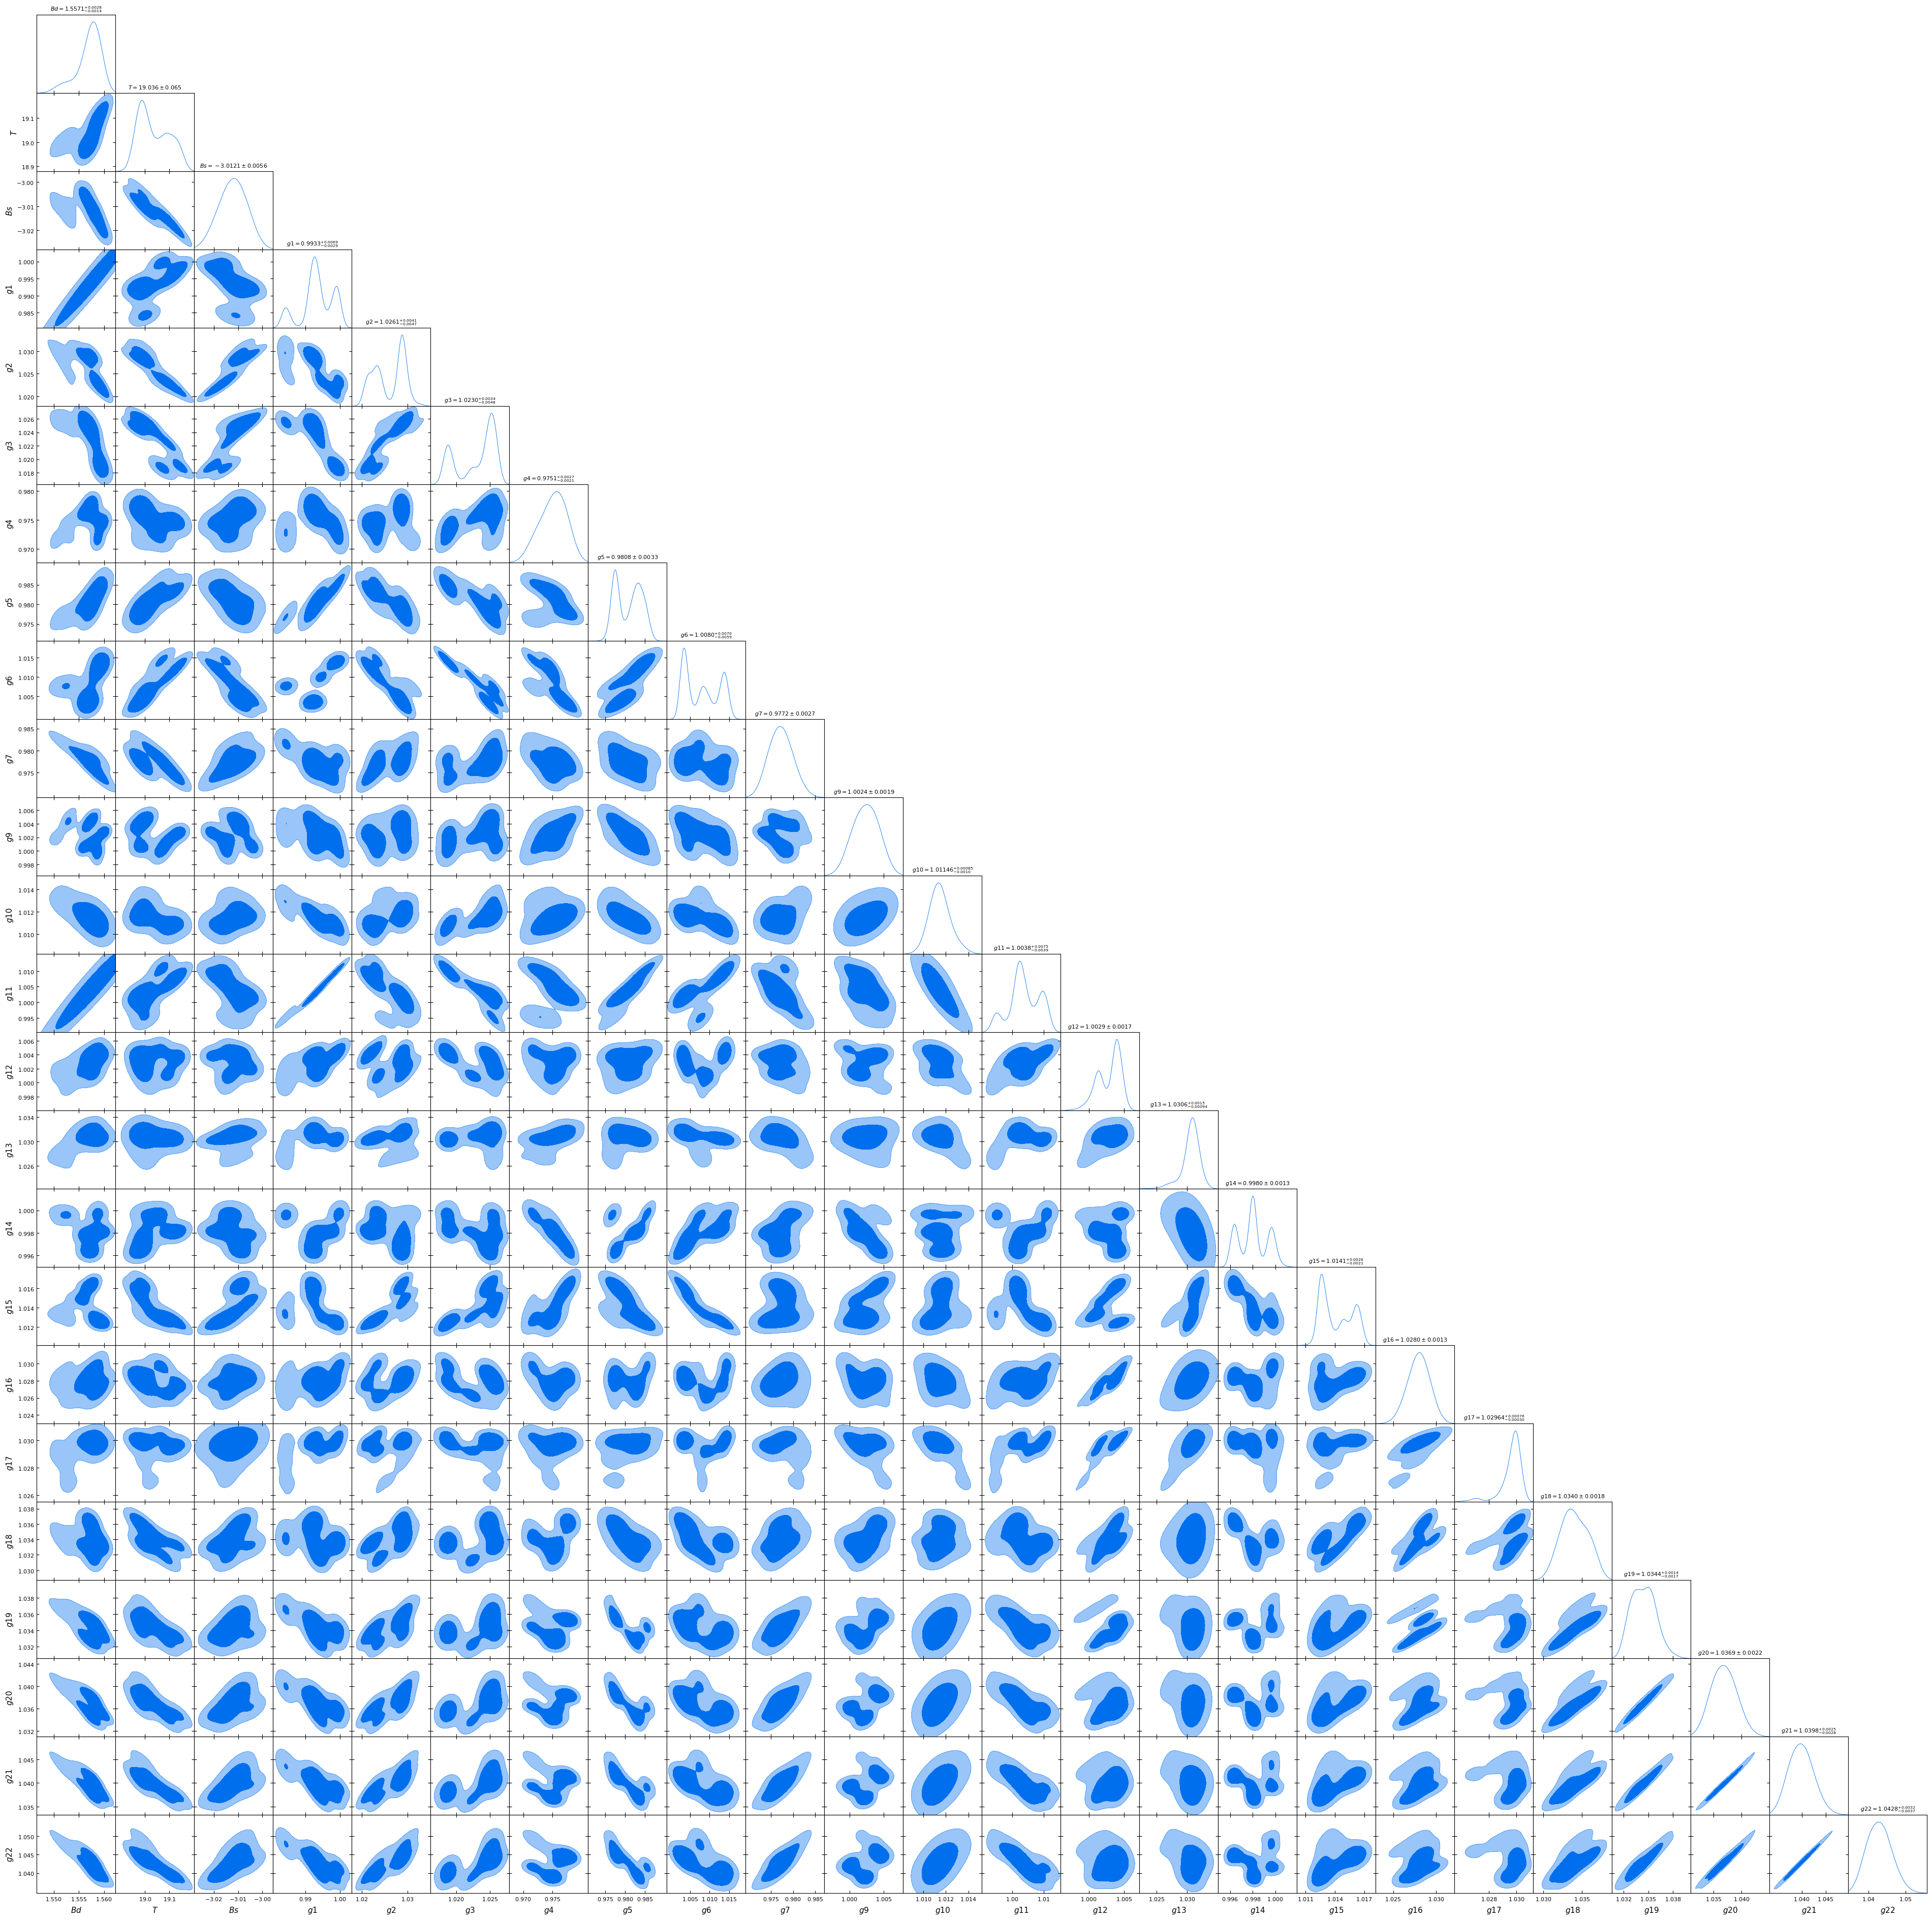

In [15]:

s1 = MCSamples(samples=new_samples, names=["Bd", "T", "Bs",  "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ], labels=["Bd", "T", "Bs",  "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ], label='21g')
g = plots.get_subplot_plotter()
g.triangle_plot([s1], filled=True, title_limit= True)
plt.show()